In [2]:
%run import_libs.py

### get data

In [3]:
df_train = get_train_data(TRAIN_PATH='./data/train.parquet')
num_features = pd.read_csv("num_feats_after_filtering.csv")["0"].to_list()

df_train_agg = get_df_w_aggrs(df=df_train, feats=num_features)
df_train_target = get_target(TARGET_PATH='./data/train_labels.csv')
df_train = get_train_data_with_target_merged(df_train=df_train_agg, df_train_target=df_train_target)

(458913, 151)
(458913, 151)
(458913, 151)
(458913, 162)
(458913, 616)


In [4]:
df_test = get_test_data(TEST_PATH='./data/test.parquet')
df_test = get_df_w_aggrs(df=df_test, feats=num_features)

(924621, 151)
(924621, 151)
(924621, 151)
(924621, 162)
(924621, 616)


In [5]:
df_train.head(3)

,customer_ID,P_2_min,P_3_min,P_4_min,D_39_min,D_41_min,D_42_min,D_43_min,D_44_min,D_45_min,...,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_66_last,D_68_last,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.868580,0.581678,0.0,0,0.0,NaN,NaN,0,0.708906,...,1,0,5,0,2,0,0,-1,6,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.861109,0.510142,0.0,0,0.0,NaN,0.060646,0,0.239459,...,1,0,0,0,2,3,0,-1,6,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.797670,0.381123,0.0,0,0.0,NaN,NaN,0,0.222406,...,1,0,0,0,2,3,2,-1,6,0


In [6]:
df_test.head(3)

,customer_ID,P_2_min,P_3_min,P_4_min,D_39_min,D_41_min,D_42_min,D_43_min,D_44_min,D_45_min,...,B_38_last,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_66_last,D_68_last
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.568930,0.535311,0.958618,0,0.0,0.103745,0.006272,0,0.004483,...,2,0,0,0,1,1,0,3,-1,6
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.794469,0.385655,0.000000,0,0.0,NaN,NaN,0,0.076225,...,2,1,0,4,0,2,3,0,-1,6
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.673112,0.381666,0.000000,0,0.0,NaN,0.085228,0,0.041670,...,2,0,0,4,0,1,0,3,1,4


In [7]:
cat_features = [f"{f}_last" for f in ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']]
cat_features

['B_30_last',
 'B_38_last',
 'D_114_last',
 'D_116_last',
 'D_117_last',
 'D_120_last',
 'D_126_last',
 'D_63_last',
 'D_64_last',
 'D_66_last',
 'D_68_last']

In [8]:
payment_feats = []
delinq_feats = []
spend_feats = []
balance_feats = []
risk_feats = []

for feat in list(df_train):
    if feat in cat_features:
        continue
    
    if feat[0] == 'P':
        #print(feat)
        payment_feats.append(feat)
    elif feat[0] == 'D':
        delinq_feats.append(feat)
    elif feat[0] == 'S':
        spend_feats.append(feat)
    elif feat[0] == 'B':
        balance_feats.append(feat)
    elif feat[0] == 'R':
        risk_feats.append(feat)

In [9]:
len(payment_feats) + len(delinq_feats) + len(spend_feats) + len(balance_feats) + len(risk_feats)

604

In [10]:
num_features = payment_feats + delinq_feats + spend_feats + balance_feats + risk_feats
len(num_features)

604

### LightGBM (all features)

In [ ]:
feature_cols = num_features + cat_features
X = df_train[feature_cols]
y = df_train['target'].values
groups = df_train['customer_ID'].values

params = dict(
    learning_rate   = 0.05,
    subsample       = 0.9,
    subsample_freq  = 1,          # без этой штуки subsample у lgbm не заработает
    colsample_bytree= 0.8,
    num_leaves      = 64,
    max_depth       = 5,
    n_estimators    = 350,
    objective       = 'binary',
    verbosity       = -1,
    random_state    = 42
)

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = [] # train_cv scores
y_pred_list = [] # test scores to submit

for fold, (tr_idx, va_idx) in enumerate(sgkf.split(
        X=df_train[['customer_ID', 'target']],
        y=y,
        groups=groups)):
    
    print(f"Fold {fold}")
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]
    
    model = LGBMClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric=lgb_amex_metric,
        categorical_feature=cat_features
    )
    
    y_pred = model.predict_proba(X_va)[:, 1]
    score = get_amex_metric_calculated(y_va, y_pred)
    print(f"  Amex = {score:.5f}")
    fold_scores.append(score)

    # predict test at each fold
    y_pred_list.append(model.predict_proba(df_test[feature_cols], raw_score=True))

print(f"\nMean CV Amex: {np.mean(fold_scores):.5f} ± {np.std(fold_scores):.5f}")

Fold 0
  Amex = 0.78540
Fold 1
  Amex = 0.78871
Fold 2
  Amex = 0.78870
Fold 3
  Amex = 0.78663
Fold 4
  Amex = 0.78985

Mean CV Amex: 0.78786 ± 0.00161


In [31]:
INFERENCE = True

if INFERENCE:
    sub = pd.DataFrame({'customer_ID': df_test.customer_ID,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub.to_csv('submission_lgbm_all_features.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-3.112161
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-6.483655
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-2.919210
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.519460
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.987848
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-3.867522
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1.531089
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.238545
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-0.620260


### Random Forest (all features)

### TabNet (all features)

### Backward selection (lgbm)

In [67]:
def run_backward_selection(df_train,
                           df_test,
                           target_col,
                           num_feats,
                           cat_feats,
                           group_col,
                           min_feats: int = 10,
                           random_state: int = 42):

    num, cat = num_feats.copy(), cat_feats.copy()
    history, list_imp_dfs,  step = [], [], 0
    sgkf = StratifiedGroupKFold(5, shuffle=True, random_state=random_state)
    test_preds_df = pd.DataFrame(index=df_test.customer_ID)  # accumulate test scores

    def n_to_drop(n):
        if n > 250: return max(1, int(n*.10))
        if n > 100: return max(1, int(n*.05))
        if n >  30: return max(1, int(n*.02))
        return 1

    def choose_params(n):
        if n > 250: return 6, 350
        if n > 100: return 5, 300
        if n >  50: return 3, 300
        if n >  10: return 2, 250
        return        2, 250

    y = df_train[target_col].values
    groups = df_train[group_col].values

    while True:
        feats = num + cat
        if len(feats) <= min_feats:
            break
        step += 1

        max_depth, n_estimators = choose_params(len(feats))
        params = dict(
            learning_rate=.05,
            subsample=.9, subsample_freq=1,
            colsample_bytree=.8,
            objective='binary',
            random_state=random_state,
            max_depth=max_depth,
            n_estimators=n_estimators,
            n_jobs=-1, # чтобы использовать все ядра CPU
            verbosity=-1
        )

        fold_scores, fold_test_raw = [], []

        print(f"\n=== Step {step} | features {len(feats)} "
              f"(num {len(num)}, cat {len(cat)}) | depth {max_depth} trees {n_estimators}")
        print()
        
        for fold, (tr_idx, va_idx) in enumerate(
                sgkf.split(X=df_train[[group_col, target_col]], y=y, groups=groups)):
            
            print(f"Fold {fold}")
            X_tr, X_va = df_train.iloc[tr_idx][feats], df_train.iloc[va_idx][feats]
            y_tr, y_va = y[tr_idx], y[va_idx]

            model = LGBMClassifier(**params)
            model.fit(X_tr, y_tr,
                      eval_set=[(X_va, y_va)],
                      eval_metric=lgb_amex_metric,
                      categorical_feature=cat)

            y_va_pred = model.predict_proba(X_va)[:,1]
            score = get_amex_metric_calculated(y_va, y_va_pred)
            fold_scores.append(score)

            # predict test at each Fold
            fold_test_raw.append(model.predict_proba(df_test[feats], raw_score=True))

            print(f"  Amex = {score:.5f}")

        mean_cv = float(np.mean(fold_scores))
        ci = stats.t.interval(.95, len(fold_scores)-1,
                              loc=mean_cv, scale=stats.sem(fold_scores))
        #print(f"Mean CV Amex = {mean_cv:.5f}  CI95 = [{ci[0]:.5f}, {ci[1]:.5f}]")
        print(f"\nMean CV Amex: {mean_cv:.5f} ± {np.std(fold_scores):.5f}")
        
        # store mean test prediction for this iteration
        test_preds_df[f'iter_{step}'] = np.mean(fold_test_raw, axis=0)

        # importance (gain)
        model_full = LGBMClassifier(**params).fit(
            df_train[feats], df_train[target_col], categorical_feature=cat)

        gains = model_full.booster_.feature_importance('gain')
        # тех. долг: по идее нужно делать list_imp_dfs.append(imp_df), который задаётся снизу
        #            однако мне хотелось сохранить без фильтра на gain > 0 и в порядке descending
        #            , а для drop_list нужен обратный порядок и фильтр на gain > 0.
        #            В общем не так красиво написал, как хотелосъ бы

        df_tmp = (
            pd.DataFrame({'feature': feats, 'gain': gains})
              .sort_values('gain', ascending=False)
        )
        df_tmp['share'] = df_tmp['gain'] / df_tmp['gain'].sum()
        list_imp_dfs.append(df_tmp)

        # importance (gain)
        imp_df = (pd.DataFrame({'feature': feats, 'gain': gains})
                    .query('gain > 0')               # keep only informative
                    .sort_values('gain', ascending=True))   # lowest first

        imp_df['share'] = imp_df['gain'] / imp_df['gain'].sum()

        k = n_to_drop(len(feats))
        drop_list = imp_df.head(k)['feature'].tolist()      # drop least‑important features     

        # print("Drop:", drop_list[:5], "..." if len(drop_list)>5 else "")

        num = [f for f in num if f not in drop_list]
        cat = [f for f in cat if f not in drop_list]

        history.append({
            'step': step,
            'n_feats_left': len(feats),
            'n_num_left': len(num),
            'n_cat_left': len(cat),
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'cv_mean': mean_cv,
            'cv_ci_lo': ci[0], 'cv_ci_hi': ci[1],
            # 'imp_df': imp_df,
            # 'dropped': drop_list
        })

    # final model
    md_final, ne_final = choose_params(len(num+cat))
    final_model = LGBMClassifier(
        learning_rate=.05, subsample=.9, subsample_freq=1,
        colsample_bytree=.8, objective='binary', random_state=random_state,
        max_depth=md_final, n_estimators=ne_final, verbosity=-1
    ).fit(df_train[num+cat], df_train[target_col], categorical_feature=cat)

    return (pd.DataFrame(history), list_imp_dfs, {'num': num, 'cat': cat},
            final_model, test_preds_df)


In [68]:
log_df, list_imp_dfs, remaining, final_model, test_preds = run_backward_selection(
    df_train=df_train,
    df_test=df_test,
    target_col='target',
    num_feats=num_features,
    cat_feats=cat_features,
    group_col='customer_ID',
    min_feats=1
)


=== Step 1 | features 615 (num 604, cat 11) | depth 6 trees 350

Fold 0
  Amex = 0.78604
Fold 1
  Amex = 0.79022
Fold 2
  Amex = 0.78922
Fold 3
  Amex = 0.78737
Fold 4
  Amex = 0.78958

Mean CV Amex: 0.78849 ± 0.00155

=== Step 2 | features 554 (num 545, cat 9) | depth 6 trees 350

Fold 0
  Amex = 0.78471
Fold 1
  Amex = 0.79026
Fold 2
  Amex = 0.78997
Fold 3
  Amex = 0.78781
Fold 4
  Amex = 0.79056

Mean CV Amex: 0.78866 ± 0.00220

=== Step 3 | features 499 (num 491, cat 8) | depth 6 trees 350

Fold 0
  Amex = 0.78620
Fold 1
  Amex = 0.79092
Fold 2
  Amex = 0.79043
Fold 3
  Amex = 0.78820
Fold 4
  Amex = 0.79037

Mean CV Amex: 0.78922 ± 0.00178

=== Step 4 | features 450 (num 442, cat 8) | depth 6 trees 350

Fold 0
  Amex = 0.78561
Fold 1
  Amex = 0.79023
Fold 2
  Amex = 0.78995
Fold 3
  Amex = 0.78815
Fold 4
  Amex = 0.79005

Mean CV Amex: 0.78880 ± 0.00176

=== Step 5 | features 405 (num 398, cat 7) | depth 6 trees 350

Fold 0
  Amex = 0.78670
Fold 1
  Amex = 0.78999
Fold 2
  Amex 

KeyboardInterrupt: 

In [ ]:
'''
# Prepare data
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection Progress")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()
'''

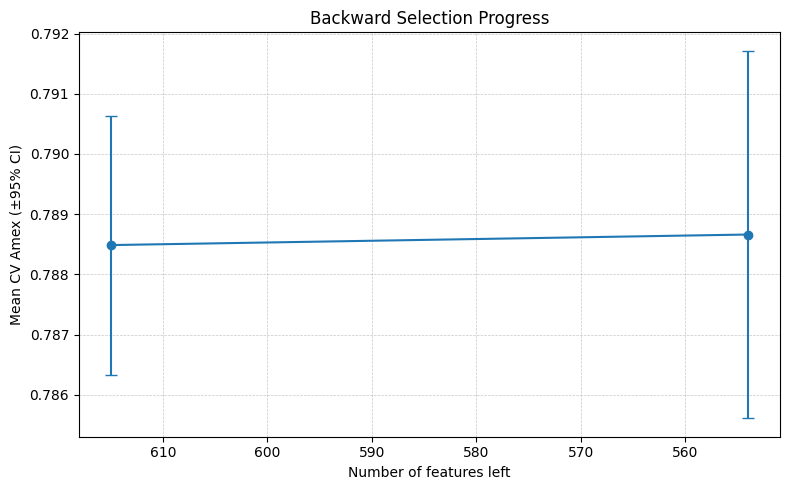

In [52]:
# Prepare data
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection Progress")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [33]:
test_preds.head(3)

,iter_1,iter_2
customer_ID,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,-3.019499,-3.069418
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,-6.646071,-6.649168
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,-2.922014,-2.885177


In [35]:
log_df

,step,n_feats_left,n_num_left,n_cat_left,max_depth,n_estimators,cv_mean,cv_ci_lo,cv_ci_hi,dropped
0,1,615,545,9,6,350,0.788487,0.786336,0.790637,"[D_86_min, D_79_min, D_145_last, D_92_max, R_1..."
1,2,554,491,8,6,350,0.788662,0.785610,0.791714,"[R_4_max, S_19_last, D_81_min, D_83_min, D_93_..."


In [ ]:
INFERENCE = True

if INFERENCE:
    sub = pd.DataFrame({'customer_ID': test_preds.index,
                        'prediction': test_preds.iter_1.values})
    #sub.to_csv('submission_lgbm_backward_selection_test_preds_615_feats_test_wo_index.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-3.019499
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-6.646071
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-2.922014
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.681319
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.977357
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-3.900490
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1.433510
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.152213
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-0.543022


In [ ]:
test_preds.iter_1.values

array([-3.01949949, -6.64607068, -2.92201373, ...,  0.15221332,
       -0.54302249, -2.4237113 ], shape=(924621,))

### LR & WoE & binning